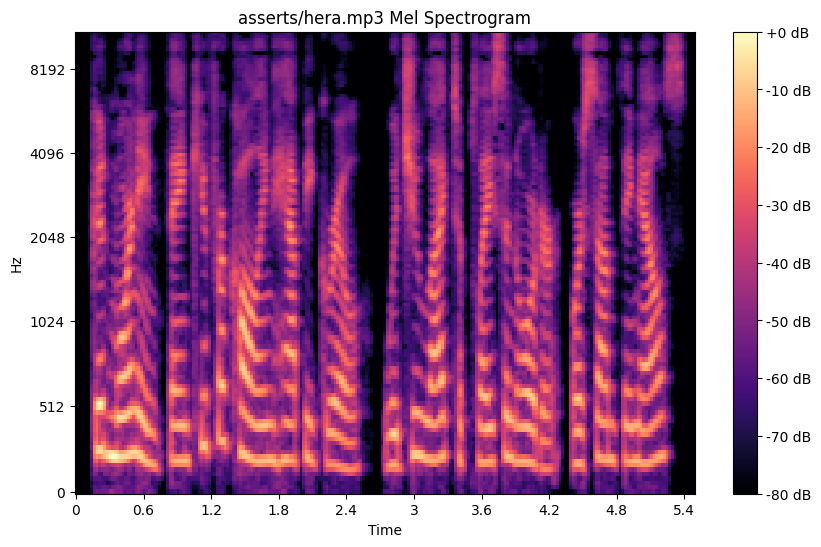

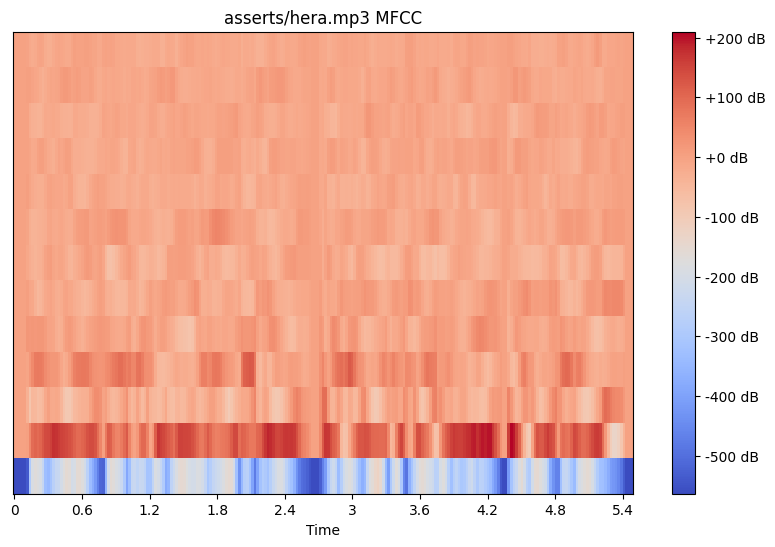

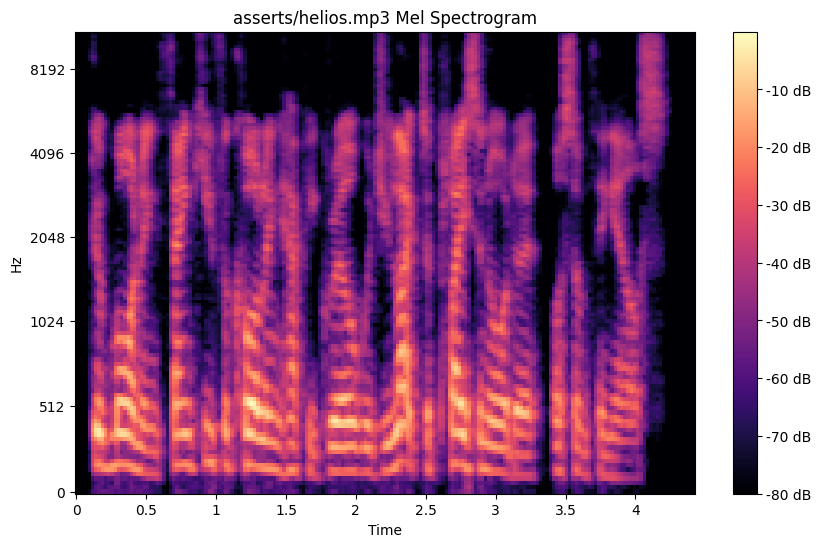

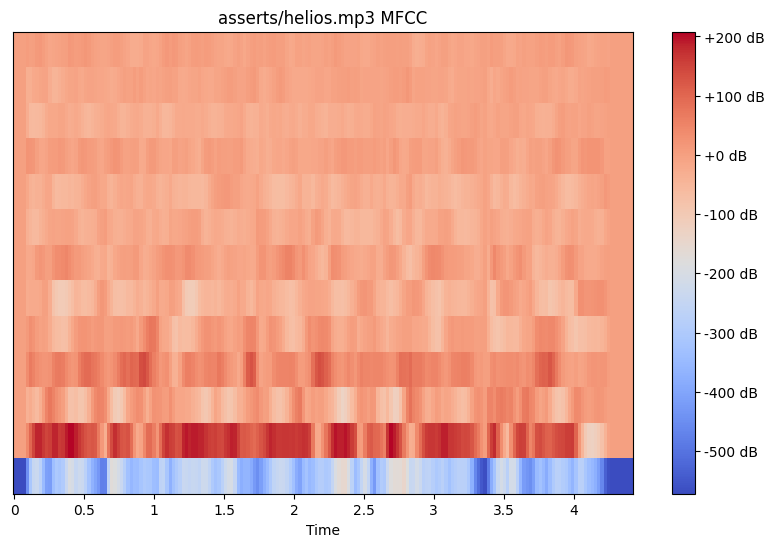

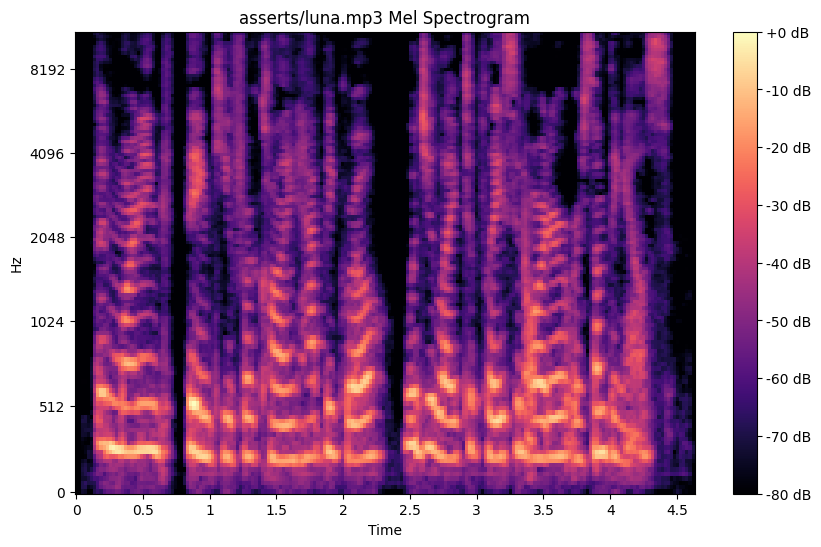

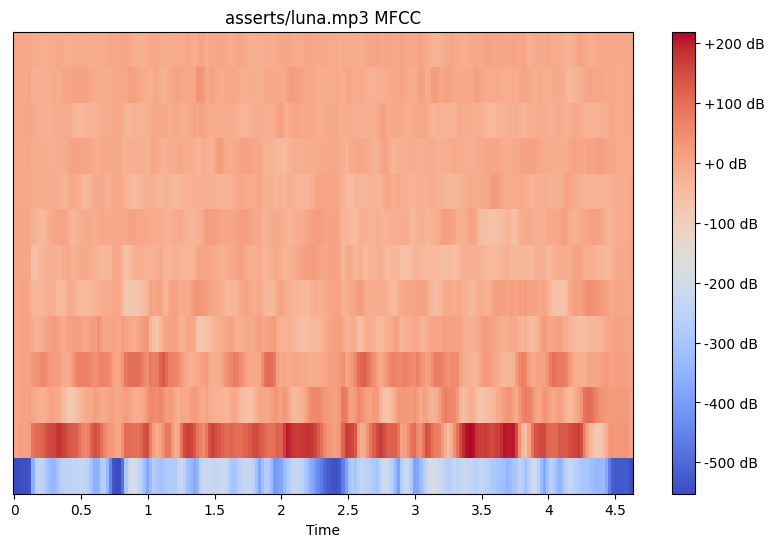

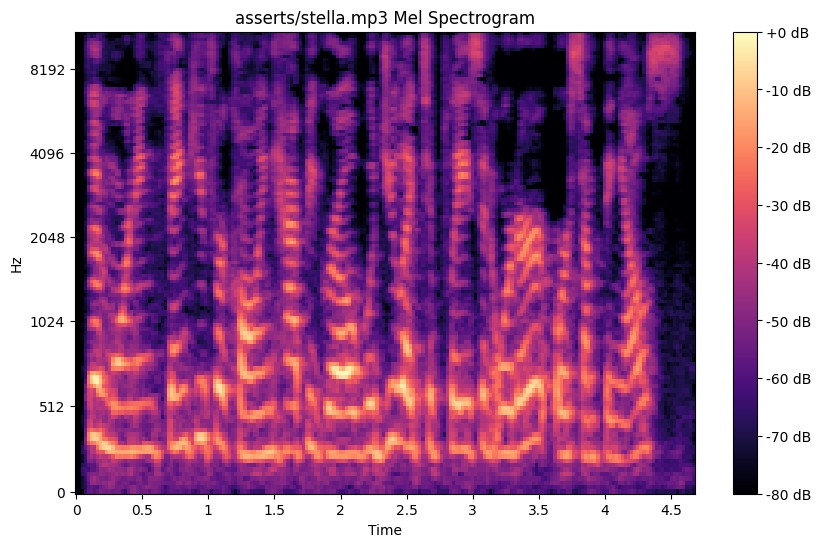

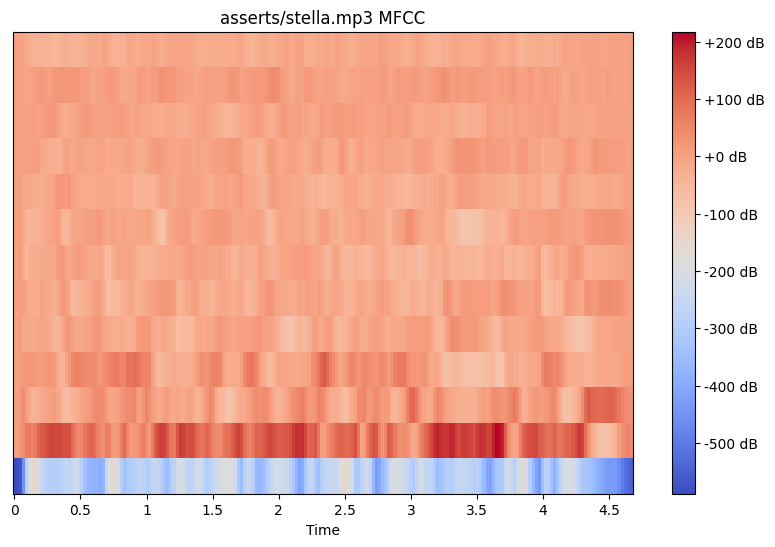

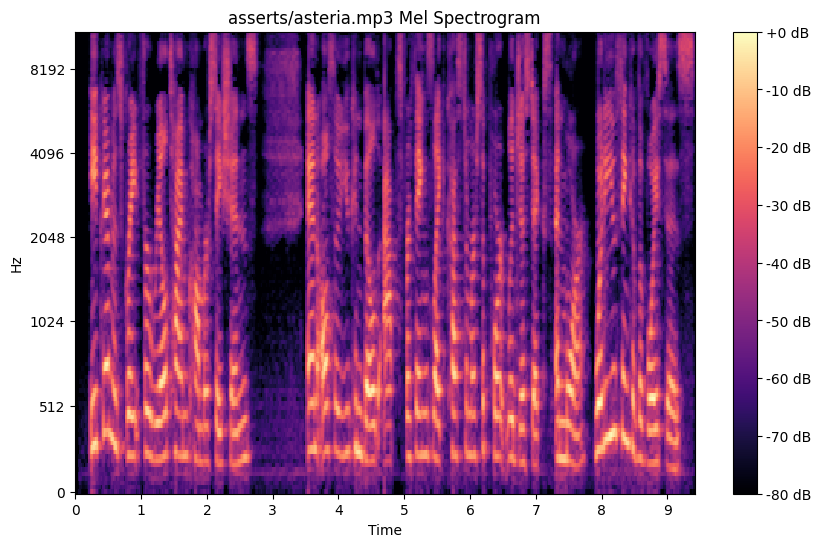

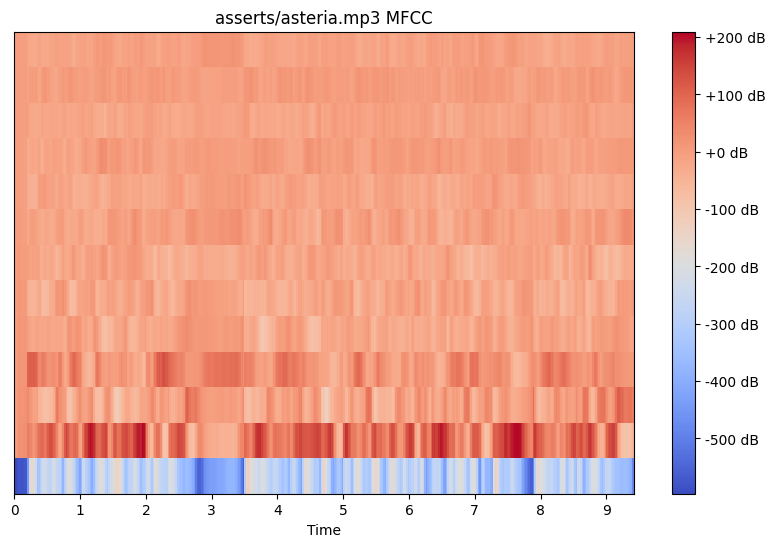

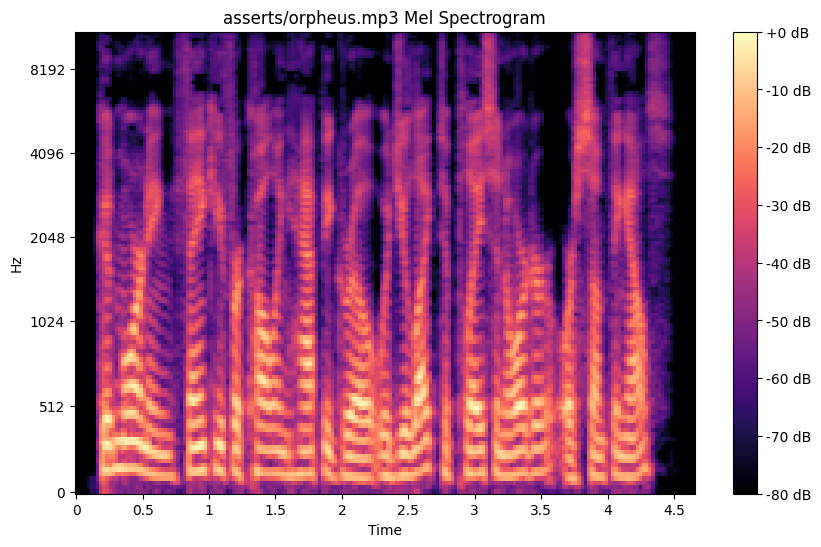

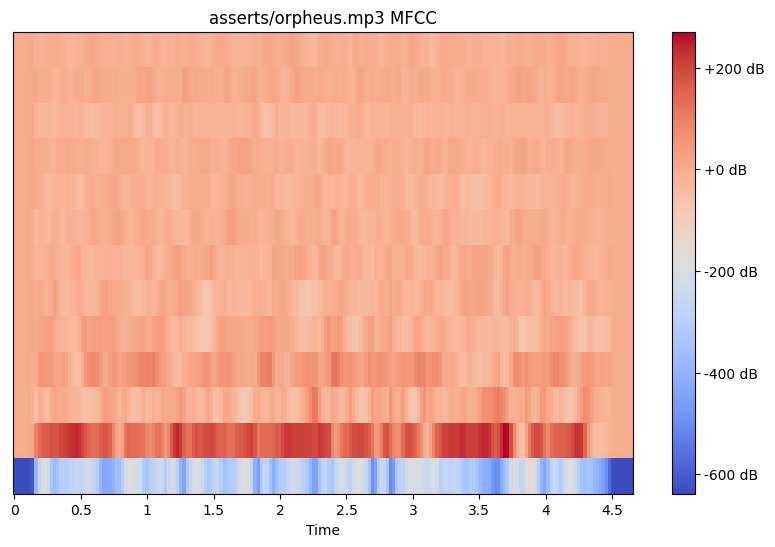

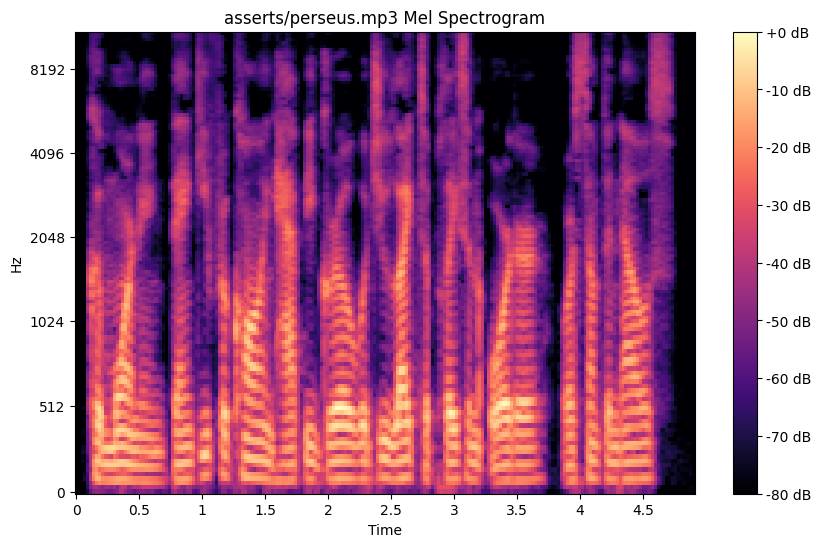

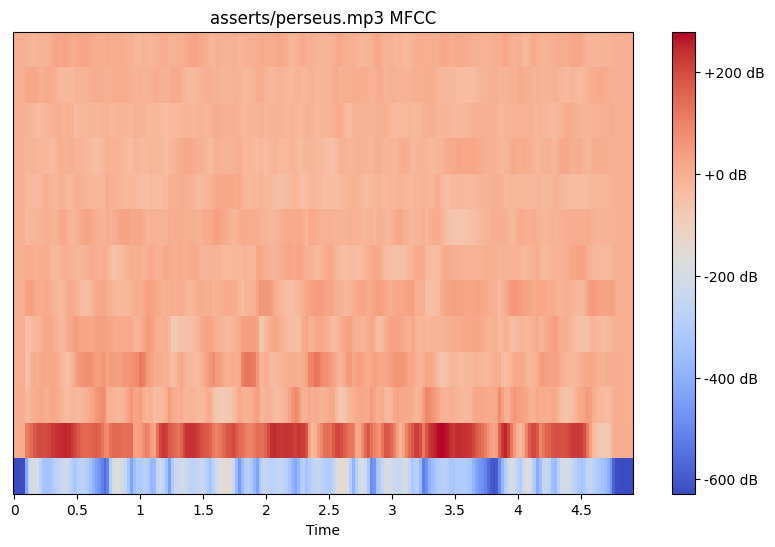

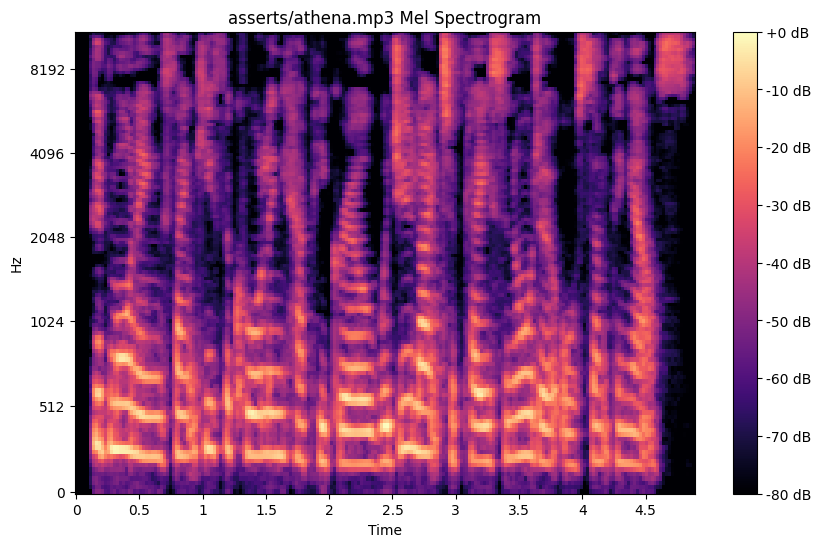

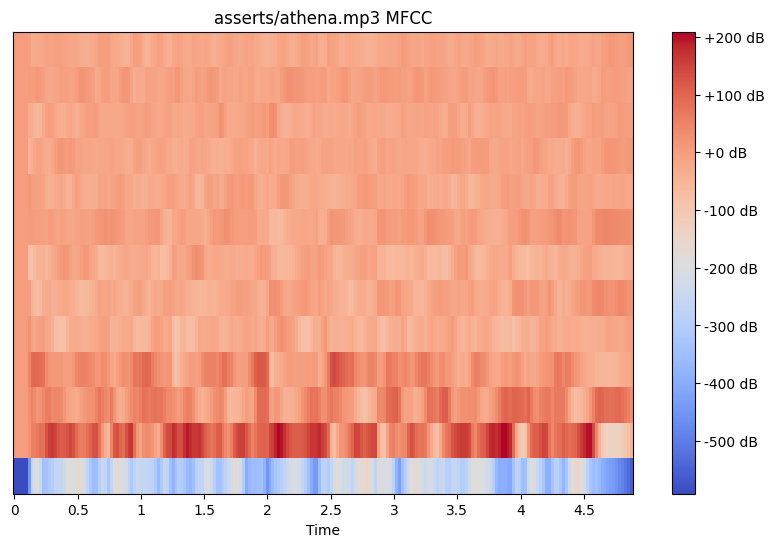

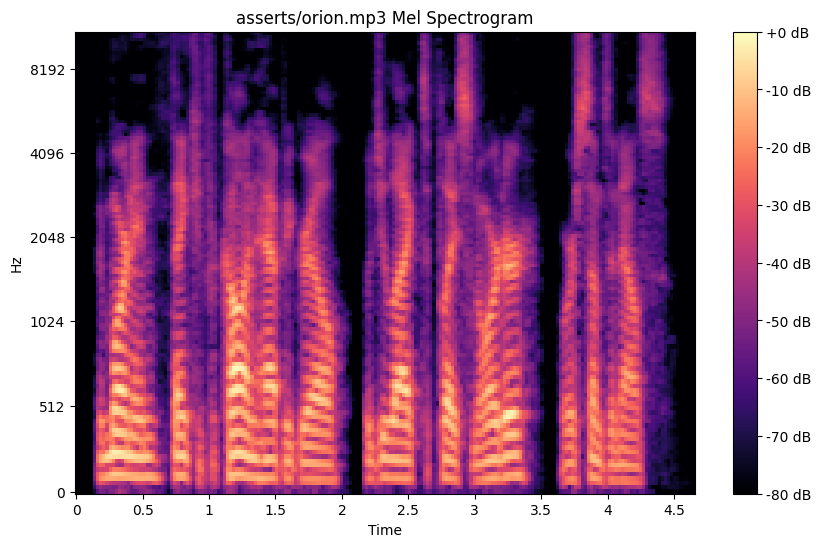

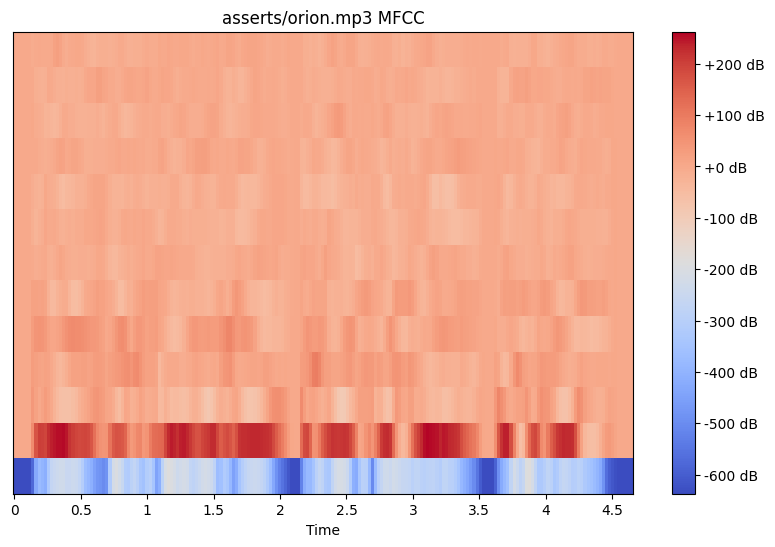

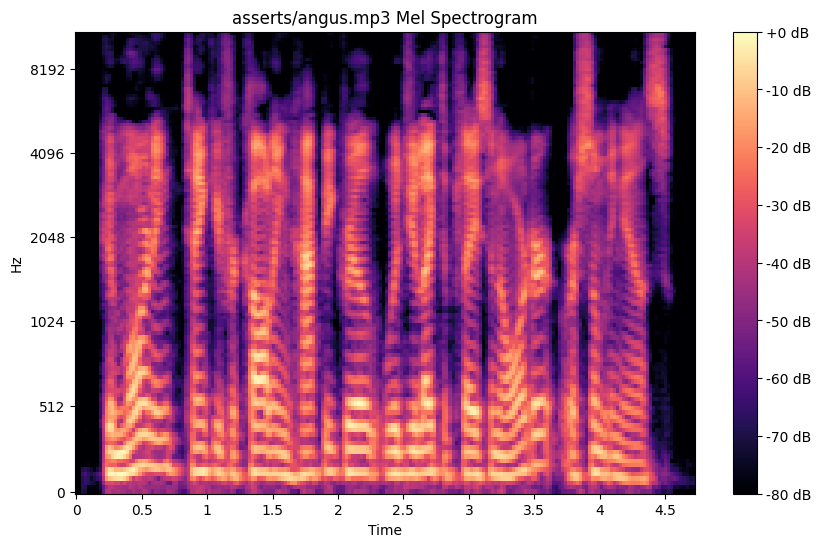

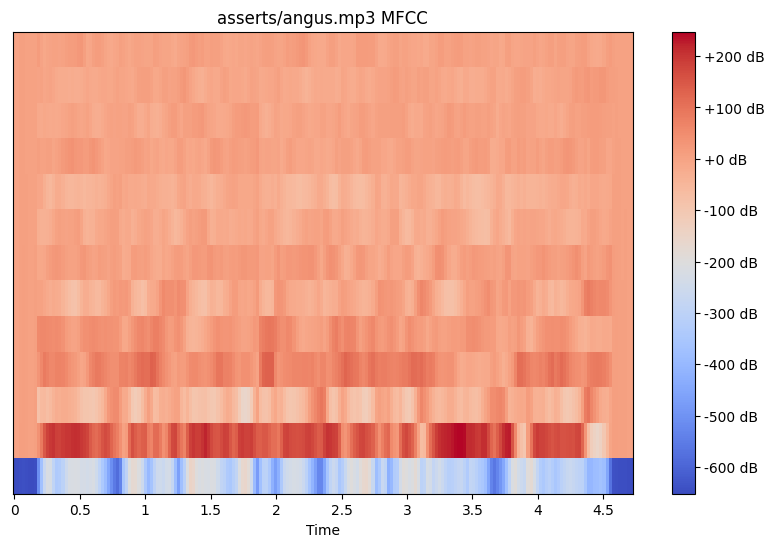

In [65]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 加载音频文件
# 示例数据
import os
asserts_folder = 'asserts'
audio_files = [os.path.join(asserts_folder, file) for file in os.listdir(asserts_folder) if os.path.isfile(os.path.join(asserts_folder, file))]

labels = list(range(len(audio_files)))  # 对应标签，如说话者ID


def plot_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # 提取梅尔频谱
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # 显示梅尔频谱图
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{file_path} Mel Spectrogram')
    plt.show()

    # 计算 MFCC 特征
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # 显示 MFCC 图
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{file_path} MFCC')
    plt.show()

for file_path in audio_files:
    plot_mfcc(file_path)

In [66]:
import torch
import torch.nn as nn


# 定义 Transformer 模型
class ContrastiveTransformerVoiceModel(nn.Module):
    def __init__(self, n_features, n_heads, n_layers, embedding_dim=256, dim_feedforward=512):
        super(ContrastiveTransformerVoiceModel, self).__init__()
        self.embedding = nn.Linear(n_features, embedding_dim)  # 映射输入特征到嵌入空间
        self.positional_encoding = PositionalEncoding(d_model=embedding_dim, max_len=5000)
        
        # Transformer 编码器层
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)

    def forward(self, x):
        x = self.embedding(x)  # 输入特征映射
        x = self.positional_encoding(x)  # 添加位置编码
        x = self.transformer_encoder(x)  # Transformer 编码
        embedding = x.mean(dim=1)  # 池化输出（声纹嵌入）
        return embedding

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

# 超参数
n_features = 128  # 128个梅尔频谱特征
n_heads = 8  # 多头注意力的头数
n_layers = 6  # Transformer 层数
n_classes = 10  # 假设是10个说话者分类任务
model = ContrastiveTransformerVoiceModel(n_features=n_features, n_heads=n_heads, n_layers=n_layers)



/Users/zxs/miniconda3/envs/voice_ai/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [67]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
class VoiceDataset(Dataset):
    def __init__(self, audio_files, labels, feature_extractor):
        self.audio_files = audio_files
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        
        # 提取特征
        mel_spectrogram = self.feature_extractor(audio_file)
        
        return torch.tensor(mel_spectrogram, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    # 分离特征和标签
    features, labels = zip(*batch)
    # 填充特征
    features_padded = pad_sequence(features, batch_first=True)
    return features_padded, torch.stack(labels)
def feature_extractor(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram.T  # 转置为 (时间, 特征) 格式



# 创建数据集
dataset = VoiceDataset(audio_files=audio_files, labels=labels, feature_extractor=feature_extractor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [68]:
import torch.optim as optim
import torch.nn.functional as F
import torch
def contrastive_loss(embeddings, temperature=0.5):
    # 计算相似度矩阵
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    
    # 计算对角线上的相似度（即自身与自身的相似度）
    self_similarity = torch.diag(similarity_matrix)
    
    # 计算对比损失
    exp_sim = torch.exp(similarity_matrix / temperature)
    exp_self_sim = torch.exp(self_similarity / temperature)
    
    # 计算每个样本的损失
    loss = -torch.log(exp_self_sim / (exp_sim.sum(dim=1) - exp_self_sim))
    
    # 返回平均损失
    return loss.mean()

def train_model(model, dataloader, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for inputs, _ in dataloader:  # Unsupervised learning does not require labels
            optimizer.zero_grad()
            embeddings = model(inputs)
            loss = contrastive_loss(embeddings)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader, optimizer)

Epoch [1/10], Loss: -0.2116
Epoch [2/10], Loss: -0.2858
Epoch [3/10], Loss: -0.4047
Epoch [4/10], Loss: -0.5686
Epoch [5/10], Loss: -0.9168
Epoch [6/10], Loss: -0.8034
Epoch [7/10], Loss: -0.2885
Epoch [8/10], Loss: -0.0106
Epoch [9/10], Loss: -0.0034
Epoch [10/10], Loss: -0.0039


In [69]:
from sklearn.metrics.pairwise import cosine_similarity


# 获取asserts文件夹下所有文件的路径
test_audio = 'asteria_test.mp3'

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    
    test_feature = feature_extractor(test_audio)
    test_input = torch.tensor(test_feature, dtype=torch.float32).unsqueeze(0)  # 扩展为 batch_size 维度

    # 获取模型输出
    embedding = model(test_input)


    for file in audio_files:
        feature = feature_extractor(test_audio)
        input = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)  # 扩展为 batch_size 维度
        embed = model(input)
        similarity_scores=cosine_similarity(embedding.cpu().numpy(), embed.cpu().numpy())
        print(f"Similarity {file} scores:", similarity_scores)# 使用训练好的模型进行推理

    

Similarity asserts/hera.mp3 scores: [[1.0000001]]
Similarity asserts/helios.mp3 scores: [[1.0000001]]
Similarity asserts/luna.mp3 scores: [[1.0000001]]
Similarity asserts/stella.mp3 scores: [[1.0000001]]
Similarity asserts/asteria.mp3 scores: [[1.0000001]]
Similarity asserts/orpheus.mp3 scores: [[1.0000001]]
Similarity asserts/perseus.mp3 scores: [[1.0000001]]
Similarity asserts/athena.mp3 scores: [[1.0000001]]
Similarity asserts/orion.mp3 scores: [[1.0000001]]
Similarity asserts/angus.mp3 scores: [[1.0000001]]


Moved pleasant_man_test.wav to asserts/pleasant_man
